<a href="https://colab.research.google.com/github/patelivan/CA-Housing-Prices-/blob/master/Linear_Regression_Senior_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the R magic
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R
# Load the libraries
library(tidyverse)
library(dplyr)
library(stargazer)
library(mlr)
library(ggfortify)
library(readr)
library(moments)
library(fastDummies)

In [ ]:
%%R
# Read the data
fixed_model_2010_2014 <- read_csv('/content/drive/MyDrive/2010-2014.csv') 
fixed_model_2015_2018 <- read_csv('/content/drive/MyDrive/2015-2018.csv') 

fixed_model_2010_2014 <- fixed_model_2010_2014 %>% select(-X1)
fixed_model_2015_2018 <- fixed_model_2015_2018 %>% select(-X1)

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  year = col_double(),
  NAME_county = col_character(),
  Coastal = col_character(),
  median.age.estimate = col_double(),
  median.number.rooms.estimate = col_double(),
  renter_occupied_perc = col_double(),
  log_house_values_estimate = col_double(),
  log_county_income_estimate = col_double(),
  travel_time_per_person = col_double()
)


R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  year = col_double(),
  NAME_county = col_character(),
  Coastal = col_character(),
  median.age.estimate = col_double(),
  median.number.rooms.estimate = col_double(),
  renter_occupied_perc = col_double(),
  log_house_values_estimate = col_double(),
  log_county_income_estimate = col_double(),
  travel_time_per_person = col_double()
)




In [ ]:
%%R
# County Fixed Effects the traditional way
county_fe <- function(data, years){
  
  x_fe <- NULL
  
  if (years == 2010){
    x_fe <- lm(data=data, log_house_values_estimate~.-year_2010
               -`NAME_county_Alameda County, California`-Coastal)
  } else {
    x_fe <- lm(data=data, log_house_values_estimate~.-year_2015
               -`NAME_county_Alameda County, California`-Coastal)
  }

  return(x_fe)
}

In [ ]:
%%R
# 2010-2014 <= 1M and 2015-2018 <= 1M
fixed_model_2010_20142 <- fixed_model_2010_2014 %>% filter(log_house_values_estimate < log(1000001)) %>% dummy_cols(select_columns = c('year', 'NAME_county'), 
                                                                                                                    remove_selected_columns = TRUE)
fixed_model_2015_20182 <- fixed_model_2015_2018 %>% filter(log_house_values_estimate < log(1000001)) %>% dummy_cols(select_columns = c('year', 'NAME_county'), 
                                                                                                                    remove_selected_columns = TRUE)

In [ ]:
%%R
# get the model results and diagnostics plot
county_2010_2014_FE <- county_fe(fixed_model_2010_20142, 2010)
county_2015_2018_FE <- county_fe(fixed_model_2015_20182, 2015)

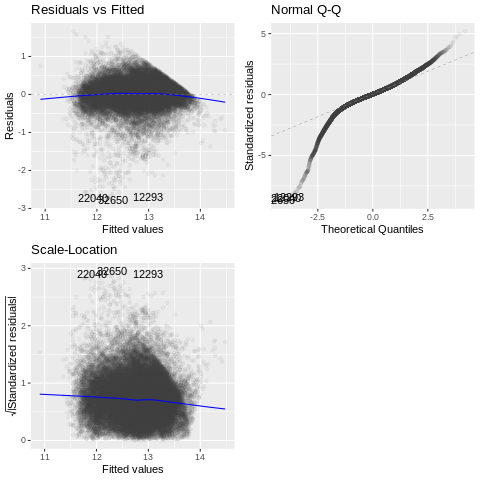

In [ ]:
%%R
# 2010-2014 <= 1M
autoplot(county_2010_2014_FE, which=1:3, nrow=2, ncol=2, alpha=0.05)

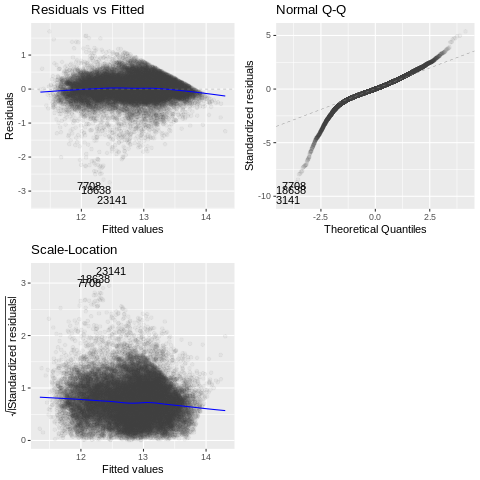

In [ ]:
%%R
# 2015-2018 <= 1M
autoplot(county_2015_2018_FE, which=1:3, nrow=2, ncol=2, alpha=0.05)

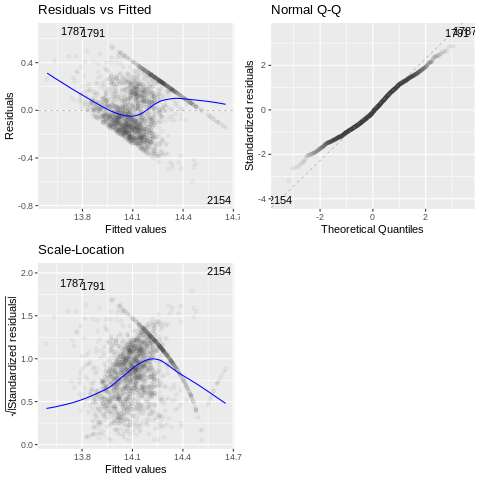

In [ ]:
%%R
# 2015-2018 >= 1M
fixed_model_2015_20183 <- fixed_model_2015_2018 %>% filter(log_house_values_estimate >= log(1000001))%>% dummy_cols(select_columns = c('year', 'NAME_county'), 
                                                                                                                    remove_selected_columns = TRUE)
county_2015_2018_FE3 <- county_fe(fixed_model_2015_20183, 2015)
autoplot(county_2015_2018_FE3, which=1:3, nrow=2, ncol=2, alpha=0.05)

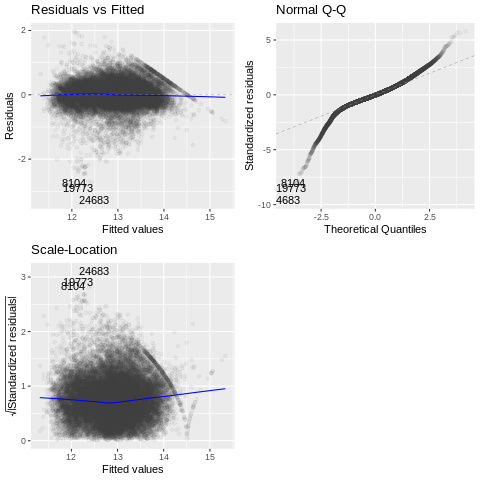

In [83]:
%%R
# 2015-2018 ALL
fixed_model_2015_20184 <- fixed_model_2015_2018 %>% dummy_cols(select_columns = c('year', 'NAME_county'), remove_selected_columns = TRUE)
autoplot(county_2015_2018_FE4, which=1:3, nrow=2, ncol=2, alpha=0.05)

In [ ]:
%%R
library(plm)
# Get the Robust Standard Errors
rob_se1 <- list(sqrt(diag(vcovHC(county_2010_2014_FE, type = "HC1"))),
                sqrt(diag(vcovHC(county_2015_2018_FE, type = "HC1"))),
                sqrt(diag(vcovHC(county_2015_2018_FE3, type = "HC1"))),
                sqrt(diag(vcovHC(county_2015_2018_FE4, type = "HC1"))))

# Print the results
stargazer(county_2010_2014_FE, county_2015_2018_FE, county_2015_2018_FE3, county_2015_2018_FE4,
          type='text', se=rob_se1,
          column.labels = c("2010-2014 < 1M", "2015-2018 < 1M", "2015-2018 >= 1M", "2015-2018 All"), out = 'CountyFE.html')


R[write to console]: 
Attaching package: ‘plm’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, lag, lead





                                                                                                Dependent variable:                                               
                                                 -----------------------------------------------------------------------------------------------------------------
                                                                                             log_house_values_estimate                                            
                                                        2010-2014 < 1M               2015-2018 < 1M             2015-2018 >= 1M              2015-2018 All        
                                                              (1)                          (2)                        (3)                         (4)             
------------------------------------------------------------------------------------------------------------------------------------------------------------------
median.age.estimate  

In [ ]:
%%R
# Coastal Fixed Effects the traditional way
coastal_fe <- function(data, year){
  x <- data %>% select(-NAME_county) %>% dummy_cols(select_columns = 'year', remove_selected_columns = TRUE)
  model <- NULL
  
  if (year==2010){
    model <- lm(data=x, log_house_values_estimate~.-year_2010+
                  log_county_income_estimate*Coastal+renter_occupied_perc*Coastal)
  } else{
    model <- lm(data=x, log_house_values_estimate~.-year_2015+
                  log_county_income_estimate*Coastal+renter_occupied_perc*Coastal)
  }
}

In [ ]:
%%R
# < 1,000,001 Models - 2010-2014 and 2015-2018.
Coastal_2010_2014 <-  fixed_model_2010_2014 %>% filter(log_house_values_estimate < log(1000001)) %>% 
  coastal_fe(year=2010) #2010_2014 < 1,000,001

Coastal_2015_2018 <- fixed_model_2015_2018 %>% filter(log_house_values_estimate < log(1000001)) %>% 
  coastal_fe(year=2015) # 2015-2018 < 1,000,001

# >= 1,000,001 tracts for 2015-2018
Coastal_2015_20182 <- fixed_model_2015_2018 %>% filter(log_house_values_estimate >= log(1000001)) %>% 
  coastal_fe(year=2015)

# All Tracts for 2015-2018
Coastal_2015_20183 <- fixed_model_2015_2018 %>% coastal_fe(year=2015)


In [ ]:
%%R
# Robust Standard Errors
rob_se2 <- list(sqrt(diag(vcovHC(Coastal_2010_2014, type = "HC1"))),
                sqrt(diag(vcovHC(Coastal_2015_2018, type = "HC1"))),
                sqrt(diag(vcovHC(Coastal_2015_20182, type = "HC1"))),
                sqrt(diag(vcovHC(Coastal_2015_20183, type = "HC1")))
                )

stargazer(Coastal_2010_2014, Coastal_2015_2018, Coastal_2015_20182, Coastal_2015_20183, 
          type='text', se = rob_se2, column.labels = c('2010_2014 < 1,000,001','2015-2018 < 1,000,001',
                                                       '2015-2018 >= 1,000,001','2015-2018 All Tracts'))


                                                                                              Dependent variable:                                                
                                              -------------------------------------------------------------------------------------------------------------------
                                                                                           log_house_values_estimate                                             
                                                     2010< 1,000,001            2015-2018 < 1,000,001      2015-2018 >= 1,000,001       2015-2018 All Tracts     
                                                           (1)                           (2)                         (3)                         (4)             
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
CoastalNot Coastal         